In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import re,os, glob, traceback
import matplotlib.dates as mdates

## 0. Read all csv files

In [178]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_e = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/junk/2019_emo.csv')
df_e.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_e = df_e.loc[:, ~df_e.columns.str.match('Unnamed')]

df_2019 = pd.merge(df, df_e[['id', 'user_id', 'race', 'emotion']],  how='left', on=['id','user_id'])
df_2019.shape

df.shape, df_e.shape, df_2019.shape

((2799726, 17), (1811516, 19), (2799726, 19))

In [180]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_e = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/junk/2021_emo.csv')
df_e.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_e = df_e.loc[:, ~df_e.columns.str.match('Unnamed')]

df_2021 = pd.merge(df, df_e[['id', 'user_id', 'race', 'emotion']],  how='left', on=['id','user_id'])
df_2021.shape

df.shape, df_e.shape, df_2021.shape

((2553235, 17), (1723470, 19), (2553235, 19))

In [180]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_e = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/junk/2021_emo.csv')
df_e.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_e = df_e.loc[:, ~df_e.columns.str.match('Unnamed')]

df_2021 = pd.merge(df, df_e[['id', 'user_id', 'race', 'emotion']],  how='left', on=['id','user_id'])
df_2021.shape

df.shape, df_e.shape, df_2021.shape

((2553235, 17), (1723470, 19), (2553235, 19))

# Radar plot

In [307]:
# Safely evaluate the string representations of lists
import ast
def safe_literal_eval(val):
    try:
        # Check if val is already a list
        if isinstance(val, list):
            return val
        # Convert val to list if it's a string
        if pd.notna(val):
            return ast.literal_eval(val)
        return []
    except (ValueError, SyntaxError):
        return []
    
def extract_emotions(data):
    unique_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']
    data['emotion'] = data['emotion'].replace('', '[]')
    data['emotion'] = data['emotion'].apply(safe_literal_eval)
    df_exploded = data.explode('emotion')
    df_dummies = pd.get_dummies(df_exploded['emotion'])
    df_aggregated = df_dummies.groupby(df_exploded.index).sum()
    data = data.drop(columns='emotion').join(df_aggregated)
    return data

In [308]:
age_groups = ['<=18','19-29', '30-39', '>=40']
race_groups = ['api', 'white', 'hispanic', 'black']
columns = ['Org', 'Person', 'Female', 'Male'] + age_groups + race_groups 
years = [2019, 2020, 2021]

def prepare_data(dataset):
    all_data = {}
    for i, y in enumerate(years):
        data = extract_emotions(dataset[i])    
        result_map = {c: [] for c in columns} 
        o = data[data['org'] =='is-org']
        p = data[data['org'] !='is-org']
        m = p[p['gender'] =='male']
        f = p[p['gender'] =='female']

        ages = {a: p[p['age'] == a] for a in age_groups}
        races = {r: p[p['race'] == r] for r in race_groups}

        result_map['Org'] = o[list(unique_emotions)].sum()
        result_map['Person']  = p[list(unique_emotions)].sum()
        result_map['Male']  = m[list(unique_emotions)].sum()
        result_map['Female']  = f[list(unique_emotions)].sum()

        for age in age_groups:
            result_map[age] = ages[age][list(unique_emotions)].sum()
        for race in race_groups:
            result_map[race] = races[race][list(unique_emotions)].sum()

        all_data[y] = result_map
    return all_data

In [330]:
def plot_radar(ax, groups,  data, groupname, ylim):
    red_rgb = '#E24A33'
    blue_rgb = '#348ABD'
    green_rgb = '#32CD32'
    yellow_rgb = '#FFD700'
    colors = [blue_rgb, red_rgb, green_rgb, yellow_rgb]

    feature = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']
    N= len(feature)
    line_styles = ['-', '--', '-.', ':']

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    values = []
    for j, g in enumerate(groups):      
        values = data[g].tolist()
        ax.plot(angles + angles[:1], values + values[:1], color=colors[j], linestyle=line_styles[j], 
                marker=markers[j], markersize=6, linewidth=2, label=g)
        # ax.fill(angles + angles[:1], values + values[:1], alpha=0.25, color=colors[j])
    ax.set_ylim(0.0, ylim)  
    ax.set_thetagrids(np.degrees(angles), feature)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    ax.grid(True)
    if len(groups) > 2:
        plt.yticks(np.arange(0.0, 0.5, step=0.1), fontsize=8)  # Set y-ticks to match the zoom level
    ax.legend(loc='upper left', bbox_to_anchor=(1.15,1), ncol=1, frameon=True, fancybox=True, shadow=False, fontsize=8)

In [332]:
def plot_all_trends(data, main_title, filename):
    fig, axs = plt.subplots(3, 2, figsize=(13, 12), subplot_kw={'polar': True})  # Adjust the grid size (3x2) and figure size as needed
    axs = axs.flatten()
    
    params = [
        (['Org', 'Person'], 'User Type'),
        (['<=18', '19-29', '30-39', '>=40'], 'Age Group'),
        (['Male', 'Female'], 'Gender'),
        (['api', 'white', 'hispanic', 'black'], 'Race'),
        # (['neu', 'pos', 'neg'], 'Sentiment')
    ]
    ylim = [0.4, 0.4, 0.4, 0.4]

    for i, (groups, groupname) in enumerate(params):
        plot_radar(axs[i], groups, data, groupname, ylim[i])
        axs[i].set_title(f'By {groupname}', fontsize=12)  # Individual subplot titles
    
    # Remove any empty subplots if there are fewer plots than subplots
    for j in range(len(params), len(axs)):
        fig.delaxes(axs[j])
        
    plt.subplots_adjust(top=0.95)  
    fig.suptitle(main_title, fontsize=16)
    plt.subplots_adjust(wspace=0.2,hspace=0.3, top=0.90)  

    plt.savefig(filename+'00_radar_plots.png', bbox_inches='tight')
    plt.show()

In [ ]:
# all_data = prepare_data([df_2019, df_2020, df_2021])

In [335]:
data

,Org,Person,Female,Male,<=18,19-29,30-39,>=40,api,white,hispanic,black
anger,35497,380328,169231,211097,152327,87572,81364,59065,69665,282339,25373,2951
anticipation,8025,49872,20847,29025,18186,10018,12917,8751,8350,37760,3361,401
disgust,45896,489719,219940,269779,198947,111416,104375,74981,91198,361810,32842,3869
fear,1990,26189,14472,11717,12566,6281,4557,2785,5267,18847,1864,211
hopeless,76,1291,684,607,657,296,216,122,317,866,103,5
joy,42484,389473,185371,204102,166961,85314,87184,50014,75862,284114,26554,2943
love,1909,25733,14409,11324,12115,6131,4906,2581,5208,18473,1859,193
optimism,22887,192492,90690,101802,78911,41454,44745,27382,37733,139845,13292,1622
sadness,5389,80816,41748,39068,39378,18717,14553,8168,17374,57428,5394,620
surprise,213,1923,770,1153,702,407,454,360,330,1428,140,25


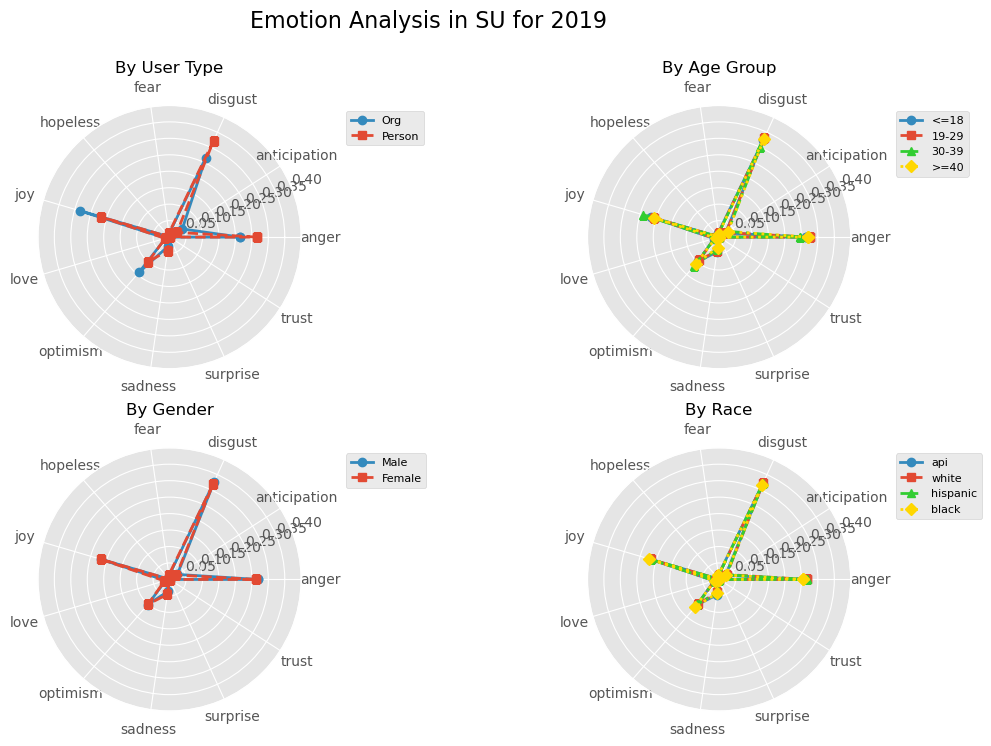

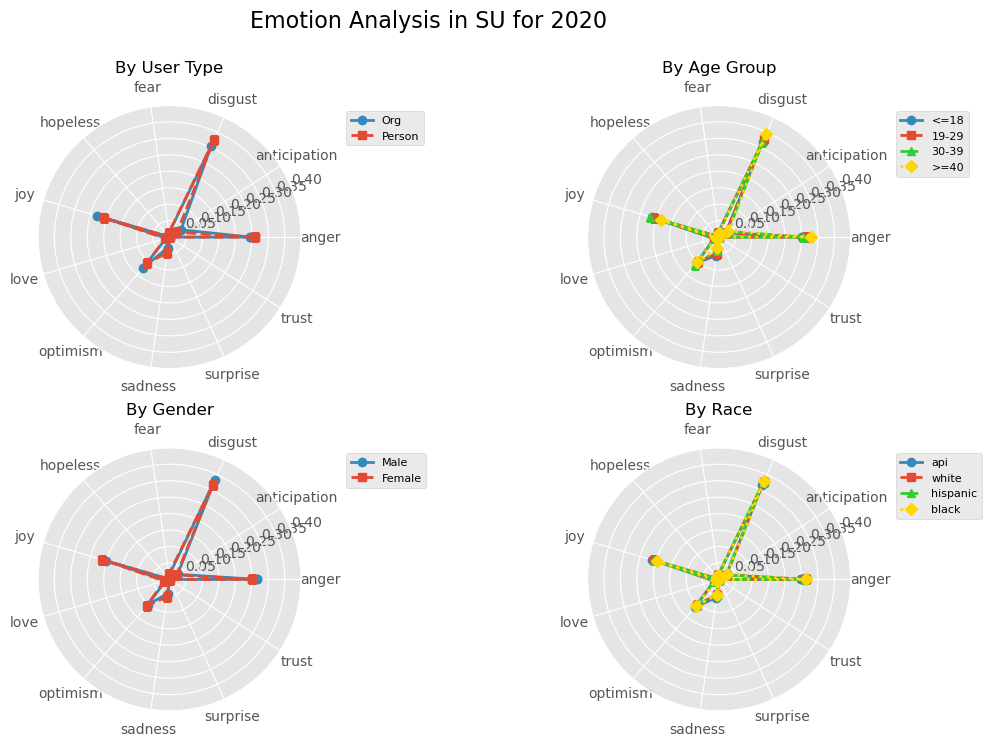

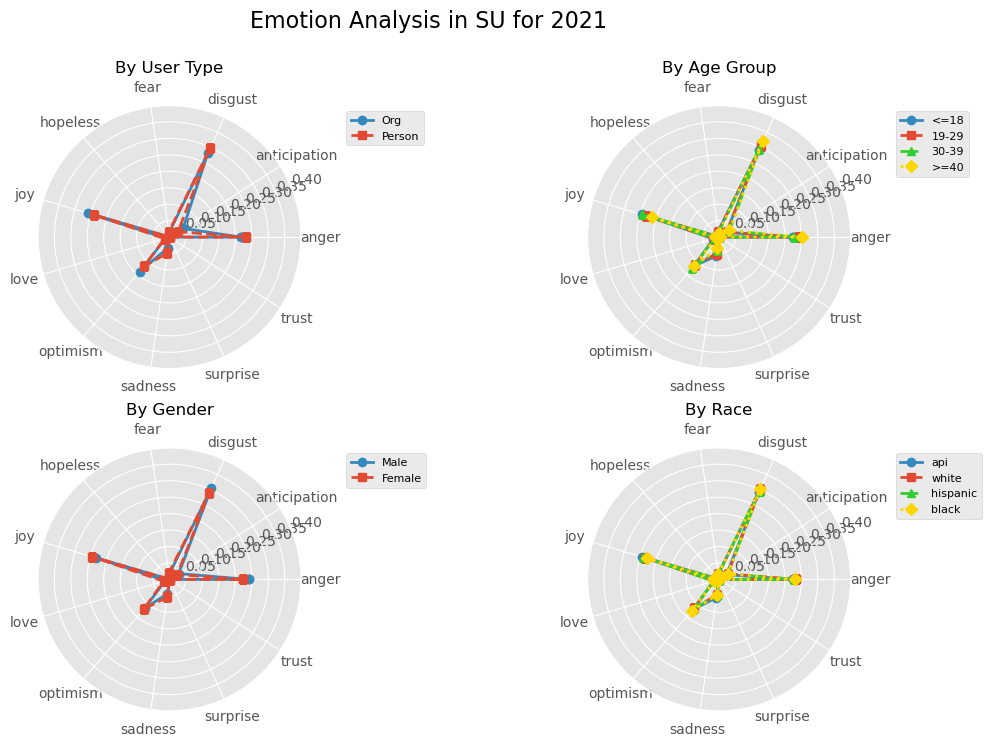

In [334]:
for i, y in enumerate(years):
    data = pd.concat(all_data[y], axis=1) 
    normalized_data = data.div(data.sum(axis=0), axis=1)
    # print(normalized_data)
    plot_all_trends(normalized_data, f'Emotion Analysis in SU Posts for {y}','')